# Generative Adversarial Networks (GANs)
## DS552 - Generative AI
**Matt Zujewski - WPI**

This notebook implements a Deep Convolutional GAN (DCGAN) trained on **CIFAR-10** (32×32 color images). It covers the full pipeline: architecture design, adversarial training, progress visualization, and latent space exploration.

---

## Theory Questions

### Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

The GAN training objective is formulated as a two-player minimax game:

$$\min_G \max_D \; \mathbb{E}_{x \sim p_{data}}[\log D(x)] + \mathbb{E}_{z \sim p_z}[\log(1 - D(G(z)))]$$

The discriminator $D$ tries to **maximize** this expression by correctly classifying real images (pushing $D(x) \to 1$) and fake images (pushing $D(G(z)) \to 0$). The generator $G$ tries to **minimize** the same expression by producing images that fool $D$ (pushing $D(G(z)) \to 1$). This creates a competitive dynamic: as $D$ gets better at telling real from fake, $G$ gets stronger gradient signal to produce more realistic images, and vice versa. At the theoretical Nash equilibrium, $G$ perfectly captures the data distribution and $D$ outputs 0.5 everywhere.

In practice, directly optimizing $\log(1 - D(G(z)))$ for $G$ saturates early in training when $D$ is confident, so we use the **non-saturating** variant: the generator instead maximizes $\log(D(G(z)))$, which provides stronger gradients when the generator is still poor. This is the formulation used in this notebook (BCE loss with real labels for the generator update).

### Q2: What is mode collapse? Why can it occur during GAN training, and how can it be mitigated?

**Mode collapse** occurs when the generator learns to produce only a small subset of the data distribution rather than its full diversity. For example, a CIFAR-10 GAN might only generate images that look like cars and ignore the other 9 classes, or produce near-identical outputs for different latent codes.

It happens because the generator can find a "safe" mode that consistently fools the current discriminator. The discriminator then adapts to reject that mode, and the generator may jump to a different single mode rather than learning to cover all modes simultaneously. This creates an oscillation rather than convergence. Contributing factors include: the discriminator being too strong (providing weak/vanishing gradients to G), poor gradient flow, and the lack of an explicit diversity incentive in the standard GAN loss.

**Mitigations include:**
- **Wasserstein loss (WGAN/WGAN-GP):** provides smoother gradients that don't vanish when D is confident, reducing the incentive to collapse.
- **Minibatch discrimination:** the discriminator sees batches of generated images and can penalize low diversity.
- **Feature matching:** G is trained to match the expected feature statistics of real data in D's intermediate layers, not just fool the final output.
- **Spectral normalization:** constrains D's Lipschitz constant, stabilizing the gradient signal.
- **Unrolled GANs:** G optimizes against a few steps of D's future, discouraging short-term mode exploitation.

In this notebook, I monitored for mode collapse by visually inspecting saved image grids every 10 epochs for diversity and checking that D(G(z)) scores did not flatline.

### Q3: Explain the role of the discriminator in adversarial training.

The discriminator serves as a **learned loss function** for the generator. Unlike fixed losses like MSE or L1 (which tend to produce blurry averages), the discriminator adapts during training, continuously raising the bar for what counts as "realistic." It takes in an image and outputs a probability that the image is real.

During each training step, D is updated to better distinguish real data from G's current outputs, and then G is updated to produce images that D classifies as real. The gradient signal that flows back through D is what teaches G to generate realistic images. This is why D's quality directly determines G's learning:
- If D is **too strong** (perfect classification), the gradients to G vanish and G cannot learn.
- If D is **too weak** (random guessing), it provides no useful signal and G learns garbage.
- The ideal is a **balanced** D that stays slightly ahead of G, providing informative gradients.

In this notebook, I tracked D(x) (discriminator's score on real images) and D(G(z)) (score on fakes) throughout training to monitor this balance. A healthy training run shows D(x) staying moderately high and D(G(z)) gradually increasing as G improves, without either saturating at 0 or 1.

### Q4: How do metrics like IS and FID evaluate GAN performance?

**Inception Score (IS)** measures two things using a pretrained Inception classifier:
1. **Quality:** each generated image should be confidently classified into a single class (low-entropy class distribution per image).
2. **Diversity:** across all generated images, the marginal class distribution should be uniform (high entropy overall).

IS = $\exp(\mathbb{E}_x [D_{KL}(p(y|x) \| p(y))])$. Higher is better. However, IS has significant limitations: it only measures class-level diversity (not intra-class variation), it's tied to ImageNet classes, and it can be gamed by generating one perfect example per class.

**Fréchet Inception Distance (FID)** compares the distribution of real images to generated images in the feature space of a pretrained Inception network. It fits multivariate Gaussians to the real and generated feature distributions and computes their Fréchet distance:

$$\text{FID} = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})$$

Lower FID is better. FID is generally preferred over IS because it captures both quality and diversity in a single metric and correlates better with human perceptual judgment. Its main downsides are sensitivity to sample size (needs ~10k+ samples for stable estimates) and reliance on Inception features, which may not capture all perceptual qualities.

In this notebook, I focused on **qualitative evaluation** (visual inspection of generated grids, interpolation smoothness) and **training diagnostics** (loss curves, D(x)/D(G(z)) scores) rather than computing IS/FID, since reliable FID estimation requires large sample sizes and a pretrained Inception model, which adds significant runtime. For a production evaluation, I would use `pytorch-fid` to compute FID over 10,000+ generated samples.

---

## Setup and Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Device setup - using MPS for M2 Mac
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Reproducibility: set seeds for all RNGs
# Note: MPS backend is not fully deterministic, so exact reproducibility
# across runs is not guaranteed on Apple Silicon, but seeding ensures
# consistent initialization and data ordering.
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create output directories
os.makedirs('gan_outputs', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

print("Setup complete!")

Using device: mps
Setup complete!


## Dataset: CIFAR-10 (Auto-Downloads)

CIFAR-10 contains 60,000 32×32 color images in 10 classes. PyTorch will download it automatically.

We'll train the GAN to generate new images across all classes.

Loading CIFAR-10 dataset (will auto-download if needed)...


100%|█████████████████████████████████████████| 170M/170M [00:14<00:00, 11.6MB/s]



Dataset loaded: 50000 images
Image size: 32×32×3
Batch size: 128
Batches per epoch: 390


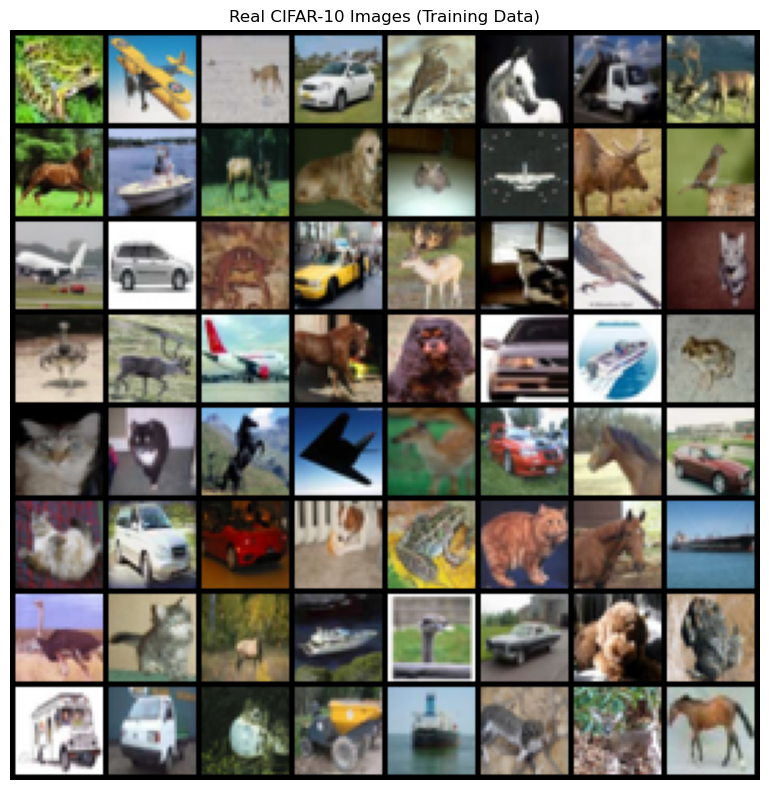

In [2]:
# Transform: normalize to [-1, 1] for tanh output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load CIFAR-10 (this will auto-download ~170MB)
print("Loading CIFAR-10 dataset (will auto-download if needed)...")
dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

print(f"\nDataset loaded: {len(dataset)} images")
print(f"Image size: 32×32×3")
print(f"Batch size: 128")
print(f"Batches per epoch: {len(dataloader)}")

# Visualize real samples
real_batch = next(iter(dataloader))[0]
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Real CIFAR-10 Images (Training Data)")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    real_batch[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.tight_layout()
plt.show()

## DCGAN Architecture

The generator and discriminator below are adapted from the DCGAN paper (Radford et al., 2015) and modified for CIFAR-10's 32×32×3 images.

### Generator: Baseline vs. This Implementation

The assignment provides a baseline TensorFlow generator for 28×28 grayscale MNIST with a `Dense` layer followed by **3 `Conv2DTranspose` layers**. This implementation replaces it with a fully convolutional architecture using **4 `ConvTranspose2d` layers** and no dense layer:

| | Baseline (MNIST, provided) | This Implementation (CIFAR-10) |
|---|---|---|
| Input | 100-d noise vector | 100-d noise vector |
| Layer 1 | `Dense(7×7×256)` + `Reshape` | `ConvTranspose2d` → **256×4×4** |
| Layer 2 | `Conv2DTranspose` → 128×7×7 | `ConvTranspose2d` → **128×8×8** |
| Layer 3 | `Conv2DTranspose` → 64×14×14 | `ConvTranspose2d` → **64×16×16** |
| Layer 4 | `Conv2DTranspose` → 1×28×28 | `ConvTranspose2d` → **3×32×32** |
| Total conv layers | 3 | **4** (added convolutional projection from noise) |
| Output channels | 1 (grayscale) | 3 (RGB) |
| Normalization | BatchNorm | BatchNorm |
| Activation | LeakyReLU / Tanh | ReLU / Tanh |

The key modification is replacing the baseline's `Dense + Reshape` with a **learned convolutional projection** (`ConvTranspose2d(100, 256, 4, 1, 0)`), which is an additional convolutional layer that the baseline does not have. This is standard DCGAN practice — the original paper recommends avoiding dense layers entirely in favor of all-convolutional architectures.

**Discriminator:** mirrors the generator with 4 `Conv2d` layers, `BatchNorm` + `LeakyReLU(0.2)`, and `Sigmoid` output. Updated for 3-channel RGB input.

**Weight initialization:** all conv and batchnorm weights initialized from $\mathcal{N}(0, 0.02)$ per the DCGAN paper.

In [3]:
class Generator(nn.Module):
    """
    DCGAN Generator for 32x32 images
    Input: 100-d noise → Output: 32×32×3 RGB
    """
    def __init__(self, latent_dim=100, ngf=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State: (ngf*4) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State: (ngf*2) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State: ngf x 16 x 16
            
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 32 x 32
        )
    
    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    """
    DCGAN Discriminator for 32x32 images
    Input: 32×32×3 RGB → Output: probability [0,1]
    """
    def __init__(self, ndf=64):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # Input: 3 x 32 x 32
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: ndf x 16 x 16
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*2) x 8 x 8
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (ndf*4) x 4 x 4
            
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


# Weight initialization from DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Initialize models
latent_dim = 100
netG = Generator(latent_dim).to(device)
netD = Discriminator().to(device)

netG.apply(weights_init)
netD.apply(weights_init)

print("Generator:")
print(f"  Parameters: {sum(p.numel() for p in netG.parameters()):,}")
print("\nDiscriminator:")
print(f"  Parameters: {sum(p.numel() for p in netD.parameters()):,}")

Generator:
  Parameters: 1,068,928

Discriminator:
  Parameters: 663,296


## Training Setup

In [4]:
# Loss and optimizers
criterion = nn.BCELoss()

lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for visualization
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Labels
real_label = 1.
fake_label = 0.

print("Training configuration:")
print(f"  Learning rate: {lr}")
print(f"  Optimizer: Adam (beta1={beta1})")
print(f"  Loss: BCE")
print(f"  Device: {device}")

Training configuration:
  Learning rate: 0.0002
  Optimizer: Adam (beta1=0.5)
  Loss: BCE
  Device: mps


## Training Loop

Training runs for **50 epochs** on CIFAR-10 (~25 min/epoch on CPU, ~25 sec/epoch on M2 MPS).

**Key implementation details:**
- Standard alternating updates: D first, then G, each batch.
- Losses and discriminator output scores (D(x), D(G(z))) are logged every 50 batches for analysis.
- **Generated image grids are saved every 10 epochs** to `gan_outputs/epoch_N.png` and displayed inline.
- Model checkpoints are saved every 10 epochs to `checkpoints/` for recovery.
- Adam optimizer with `lr=0.0002` and `beta1=0.5` (per DCGAN paper — lower beta1 helps with GAN instability).

Starting training for 50 epochs...
Progress will be saved every 10 epochs.



Epoch 1/50: 100%|██████████████████████████████| 390/390 [00:25<00:00, 15.31it/s]


[1/50] Loss_D: 0.2643 Loss_G: 4.7578 D(x): 0.8914 D(G(z)): 0.1132/0.0133


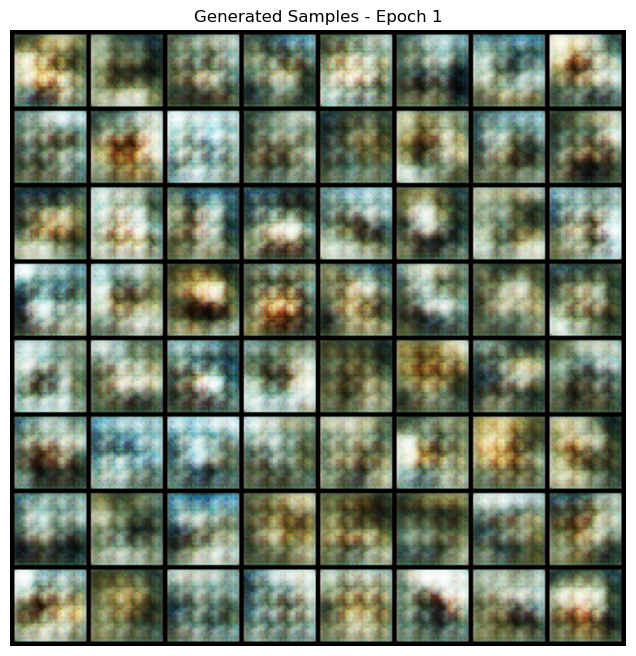

Epoch 2/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.91it/s]


[2/50] Loss_D: 0.1675 Loss_G: 4.3225 D(x): 0.8976 D(G(z)): 0.0483/0.0213


Epoch 3/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.94it/s]


[3/50] Loss_D: 0.3891 Loss_G: 2.8348 D(x): 0.7619 D(G(z)): 0.0746/0.0901


Epoch 4/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.65it/s]


[4/50] Loss_D: 0.3941 Loss_G: 3.7030 D(x): 0.8719 D(G(z)): 0.1948/0.0373


Epoch 5/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.67it/s]


[5/50] Loss_D: 0.4058 Loss_G: 3.2503 D(x): 0.7637 D(G(z)): 0.0937/0.0593


Epoch 6/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.95it/s]


[6/50] Loss_D: 0.5859 Loss_G: 2.0375 D(x): 0.7743 D(G(z)): 0.2364/0.1684


Epoch 7/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.95it/s]


[7/50] Loss_D: 0.6251 Loss_G: 2.2829 D(x): 0.7457 D(G(z)): 0.2413/0.1350


Epoch 8/50: 100%|██████████████████████████████| 390/390 [00:23<00:00, 16.90it/s]


[8/50] Loss_D: 0.9801 Loss_G: 5.4213 D(x): 0.9527 D(G(z)): 0.5479/0.0083


Epoch 9/50: 100%|██████████████████████████████| 390/390 [00:22<00:00, 16.96it/s]


[9/50] Loss_D: 1.5439 Loss_G: 5.3503 D(x): 0.9499 D(G(z)): 0.7181/0.0076


Epoch 10/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.80it/s]


[10/50] Loss_D: 0.5866 Loss_G: 2.8387 D(x): 0.8336 D(G(z)): 0.2990/0.0820


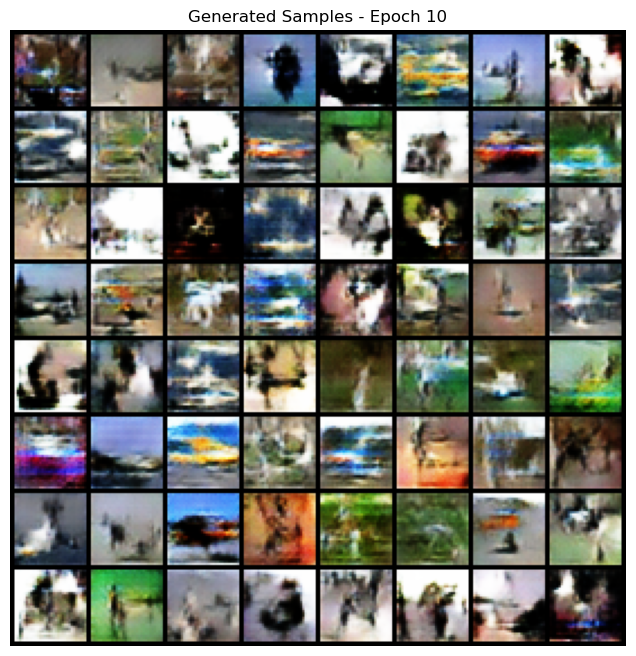

Epoch 11/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.91it/s]


[11/50] Loss_D: 0.5709 Loss_G: 2.3333 D(x): 0.7924 D(G(z)): 0.2598/0.1234


Epoch 12/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.94it/s]


[12/50] Loss_D: 0.6826 Loss_G: 1.1267 D(x): 0.5962 D(G(z)): 0.0906/0.3745


Epoch 13/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.82it/s]


[13/50] Loss_D: 0.6270 Loss_G: 1.7712 D(x): 0.6745 D(G(z)): 0.1687/0.2019


Epoch 14/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.97it/s]


[14/50] Loss_D: 0.6251 Loss_G: 1.4239 D(x): 0.6458 D(G(z)): 0.1028/0.2891


Epoch 15/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.92it/s]


[15/50] Loss_D: 0.4336 Loss_G: 2.3903 D(x): 0.8448 D(G(z)): 0.2045/0.1187


Epoch 16/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.96it/s]


[16/50] Loss_D: 1.2105 Loss_G: 0.7492 D(x): 0.3863 D(G(z)): 0.1181/0.5157


Epoch 17/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.95it/s]


[17/50] Loss_D: 0.6797 Loss_G: 1.4857 D(x): 0.5949 D(G(z)): 0.0849/0.2645


Epoch 18/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.79it/s]


[18/50] Loss_D: 0.7831 Loss_G: 1.8331 D(x): 0.7722 D(G(z)): 0.3689/0.1922


Epoch 19/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.91it/s]


[19/50] Loss_D: 0.6445 Loss_G: 2.2613 D(x): 0.7655 D(G(z)): 0.2786/0.1357


Epoch 20/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.77it/s]


[20/50] Loss_D: 0.8275 Loss_G: 2.0889 D(x): 0.7270 D(G(z)): 0.3527/0.1583


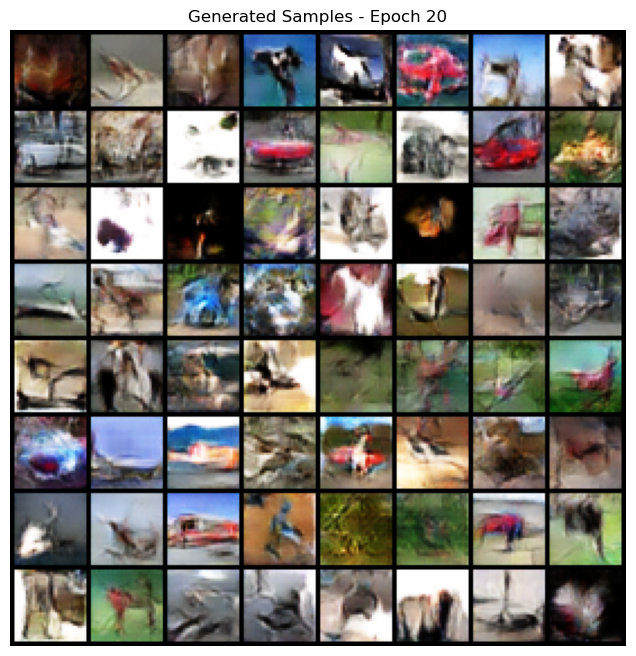

Epoch 21/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.72it/s]


[21/50] Loss_D: 0.6571 Loss_G: 2.8705 D(x): 0.8924 D(G(z)): 0.3887/0.0749


Epoch 22/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.78it/s]


[22/50] Loss_D: 0.4981 Loss_G: 2.6240 D(x): 0.7853 D(G(z)): 0.2001/0.0932


Epoch 23/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.96it/s]


[23/50] Loss_D: 0.4815 Loss_G: 2.4704 D(x): 0.8758 D(G(z)): 0.2717/0.1082


Epoch 24/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.93it/s]


[24/50] Loss_D: 0.6282 Loss_G: 1.9090 D(x): 0.7622 D(G(z)): 0.2541/0.1773


Epoch 25/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.97it/s]


[25/50] Loss_D: 0.7161 Loss_G: 1.6042 D(x): 0.7452 D(G(z)): 0.3002/0.2379


Epoch 26/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.90it/s]


[26/50] Loss_D: 1.5811 Loss_G: 3.6288 D(x): 0.9563 D(G(z)): 0.7188/0.0506


Epoch 27/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.95it/s]


[27/50] Loss_D: 0.6346 Loss_G: 1.7499 D(x): 0.7201 D(G(z)): 0.2291/0.2141


Epoch 28/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.96it/s]


[28/50] Loss_D: 0.6795 Loss_G: 1.3747 D(x): 0.6678 D(G(z)): 0.2024/0.2962


Epoch 29/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.94it/s]


[29/50] Loss_D: 2.1941 Loss_G: 6.2813 D(x): 0.9351 D(G(z)): 0.8163/0.0040


Epoch 30/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.95it/s]


[30/50] Loss_D: 0.4797 Loss_G: 2.0618 D(x): 0.8193 D(G(z)): 0.2241/0.1626


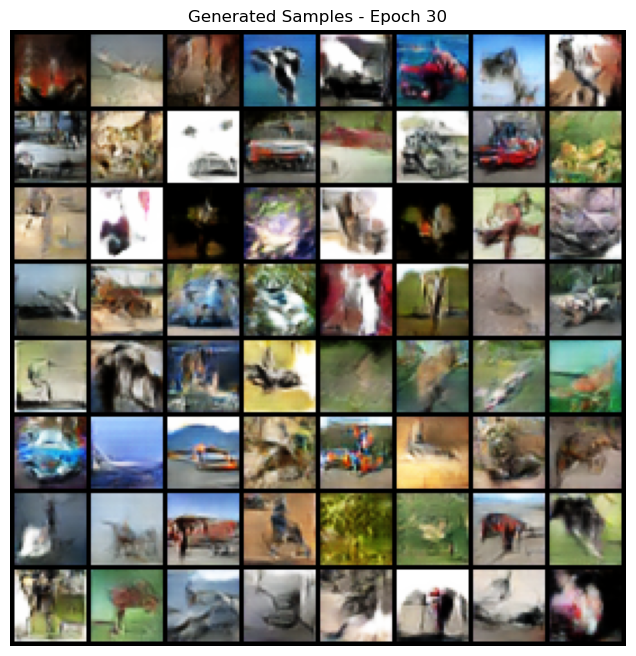

Epoch 31/50: 100%|█████████████████████████████| 390/390 [00:52<00:00,  7.45it/s]


[31/50] Loss_D: 0.5162 Loss_G: 2.0759 D(x): 0.7978 D(G(z)): 0.2218/0.1569


Epoch 32/50: 100%|█████████████████████████████| 390/390 [01:51<00:00,  3.48it/s]


[32/50] Loss_D: 0.6804 Loss_G: 1.6989 D(x): 0.6098 D(G(z)): 0.1176/0.2299


Epoch 33/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.78it/s]


[33/50] Loss_D: 0.6334 Loss_G: 3.1964 D(x): 0.8793 D(G(z)): 0.3572/0.0519


Epoch 34/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.96it/s]


[34/50] Loss_D: 0.6967 Loss_G: 2.6127 D(x): 0.8239 D(G(z)): 0.3444/0.0954


Epoch 35/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.88it/s]


[35/50] Loss_D: 0.6759 Loss_G: 2.1182 D(x): 0.8216 D(G(z)): 0.3364/0.1530


Epoch 36/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.96it/s]


[36/50] Loss_D: 0.6727 Loss_G: 1.7644 D(x): 0.6985 D(G(z)): 0.2289/0.2132


Epoch 37/50: 100%|█████████████████████████████| 390/390 [00:48<00:00,  7.97it/s]


[37/50] Loss_D: 0.4612 Loss_G: 2.5519 D(x): 0.8312 D(G(z)): 0.2063/0.1126


Epoch 38/50: 100%|█████████████████████████████| 390/390 [09:14<00:00,  1.42s/it]


[38/50] Loss_D: 0.5909 Loss_G: 1.7682 D(x): 0.7091 D(G(z)): 0.1745/0.2070


Epoch 39/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.76it/s]


[39/50] Loss_D: 0.5252 Loss_G: 2.4727 D(x): 0.7891 D(G(z)): 0.2156/0.1089


Epoch 40/50: 100%|█████████████████████████████| 390/390 [09:31<00:00,  1.47s/it]


[40/50] Loss_D: 0.4228 Loss_G: 2.3487 D(x): 0.8239 D(G(z)): 0.1836/0.1169


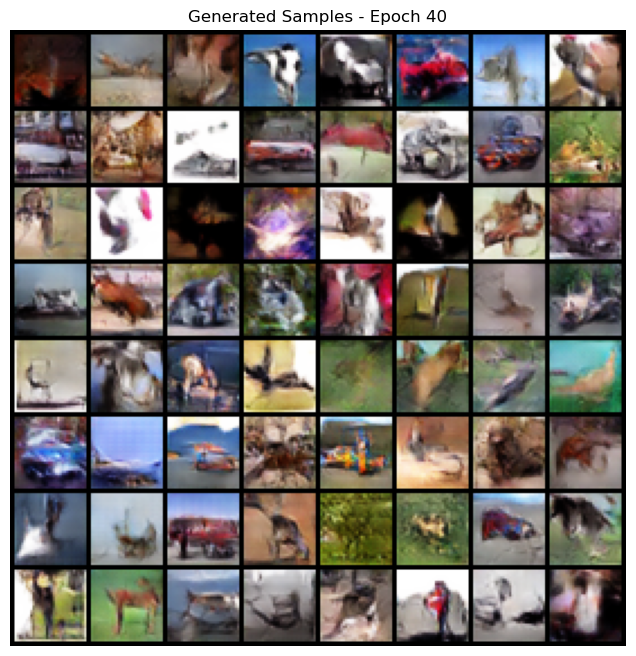

Epoch 41/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.97it/s]


[41/50] Loss_D: 0.5058 Loss_G: 2.6881 D(x): 0.8489 D(G(z)): 0.2565/0.0940


Epoch 42/50: 100%|█████████████████████████████| 390/390 [00:39<00:00,  9.92it/s]


[42/50] Loss_D: 0.5333 Loss_G: 2.1928 D(x): 0.8024 D(G(z)): 0.2320/0.1517


Epoch 43/50: 100%|█████████████████████████████| 390/390 [00:23<00:00, 16.91it/s]


[43/50] Loss_D: 1.0471 Loss_G: 4.1899 D(x): 0.9676 D(G(z)): 0.5810/0.0245


Epoch 44/50: 100%|█████████████████████████████| 390/390 [15:49<00:00,  2.44s/it]


[44/50] Loss_D: 0.5640 Loss_G: 2.0195 D(x): 0.7482 D(G(z)): 0.1933/0.1751


Epoch 45/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 17.04it/s]


[45/50] Loss_D: 0.4478 Loss_G: 2.7483 D(x): 0.8334 D(G(z)): 0.2107/0.0837


Epoch 46/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 17.04it/s]


[46/50] Loss_D: 0.5583 Loss_G: 2.0251 D(x): 0.7477 D(G(z)): 0.1932/0.1691


Epoch 47/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 17.06it/s]


[47/50] Loss_D: 0.6825 Loss_G: 1.3464 D(x): 0.5846 D(G(z)): 0.0684/0.3457


Epoch 48/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 17.02it/s]


[48/50] Loss_D: 0.8634 Loss_G: 3.4419 D(x): 0.9239 D(G(z)): 0.4609/0.0573


Epoch 49/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 17.00it/s]


[49/50] Loss_D: 0.5782 Loss_G: 3.1017 D(x): 0.8651 D(G(z)): 0.3071/0.0646


Epoch 50/50: 100%|█████████████████████████████| 390/390 [00:22<00:00, 16.98it/s]


[50/50] Loss_D: 0.4421 Loss_G: 2.9393 D(x): 0.9147 D(G(z)): 0.2686/0.0750


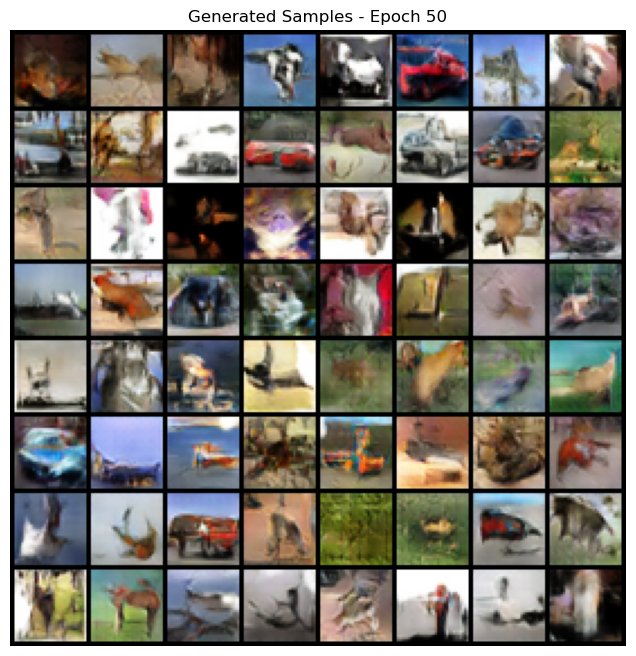


Training complete!


In [5]:
# Training metrics
G_losses = []
D_losses = []
D_x_scores = []
D_G_z_scores = []

num_epochs = 50  # Change to 100 for better quality

print(f"Starting training for {num_epochs} epochs...")
print("Progress will be saved every 10 epochs.\n")

for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        
        ############################
        # (1) Update D: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()
        
        # Train with real
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with fake
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)
        
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        
        optimizerG.step()
        
        # Save losses
        if i % 50 == 0:
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            D_x_scores.append(D_x)
            D_G_z_scores.append(D_G_z2)
    
    # Print progress
    print(f"[{epoch+1}/{num_epochs}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
          f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")
    
    # Save samples every 10 epochs
    if (epoch + 1) % 10 == 0 or epoch == 0:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title(f"Generated Samples - Epoch {epoch+1}")
        plt.imshow(np.transpose(torchvision.utils.make_grid(
            fake, padding=2, normalize=True), (1, 2, 0)))
        plt.savefig(f'gan_outputs/epoch_{epoch+1}.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'netG_state_dict': netG.state_dict(),
            'netD_state_dict': netD.state_dict(),
        }, f'checkpoints/checkpoint_epoch_{epoch+1}.pth')

print("\nTraining complete!")

## Training Analysis

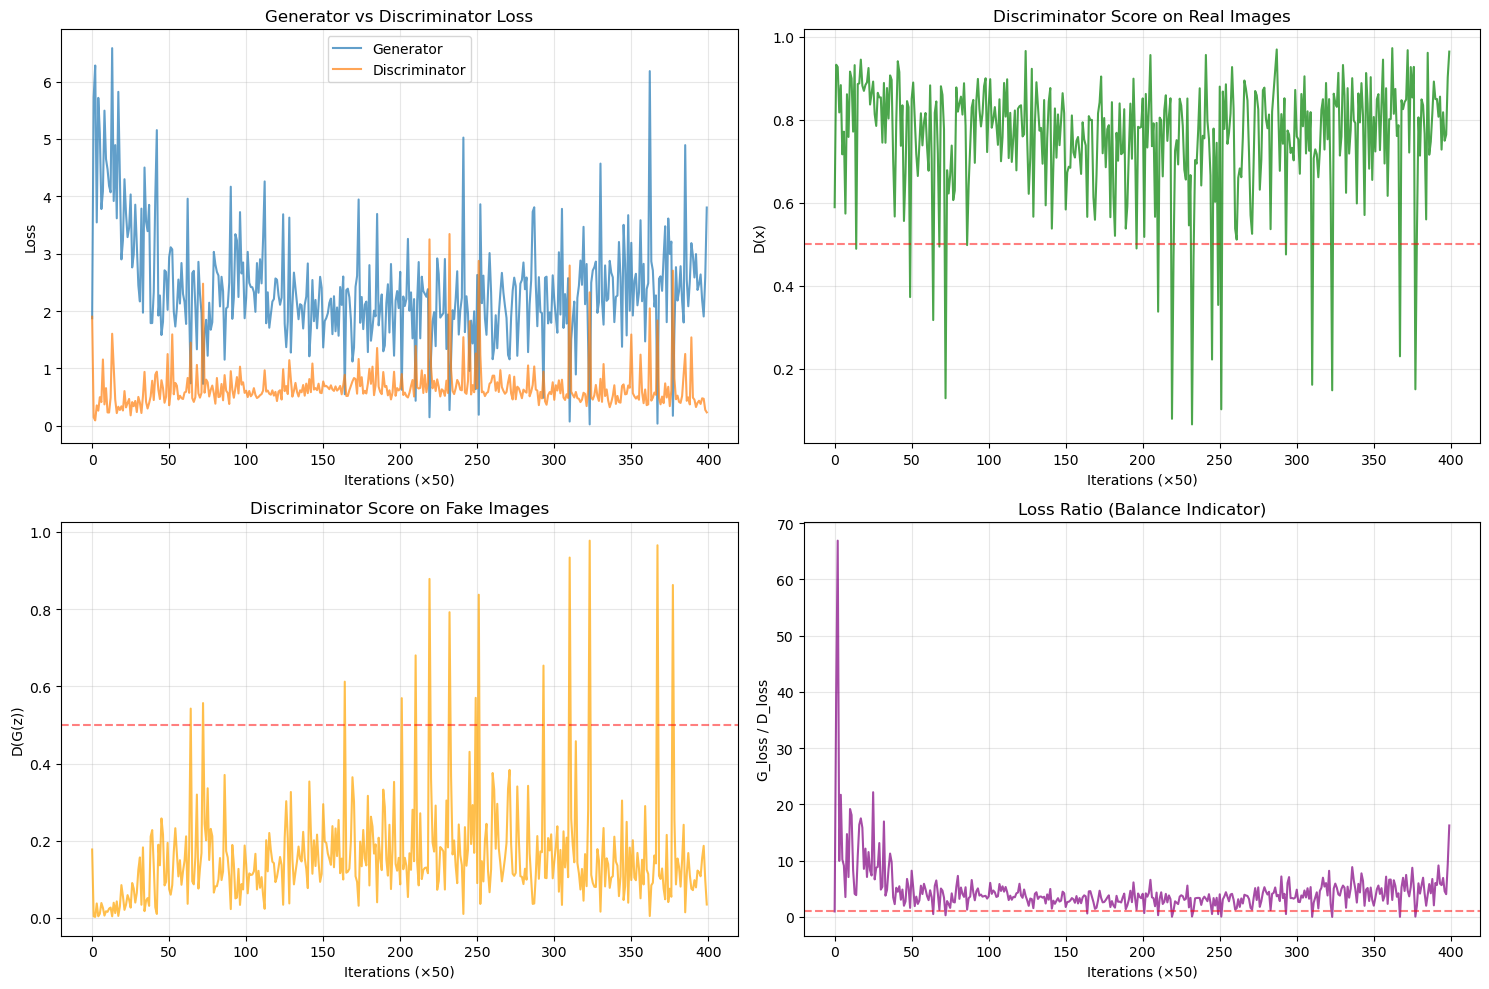

Final G loss: 3.8048
Final D loss: 0.2339
Final D(x): 0.9642
Final D(G(z)): 0.0349


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# G vs D loss
axes[0, 0].plot(G_losses, label='Generator', alpha=0.7)
axes[0, 0].plot(D_losses, label='Discriminator', alpha=0.7)
axes[0, 0].set_xlabel('Iterations (×50)')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Generator vs Discriminator Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# D(x) score
axes[0, 1].plot(D_x_scores, color='green', alpha=0.7)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Iterations (×50)')
axes[0, 1].set_ylabel('D(x)')
axes[0, 1].set_title('Discriminator Score on Real Images')
axes[0, 1].grid(alpha=0.3)

# D(G(z)) score
axes[1, 0].plot(D_G_z_scores, color='orange', alpha=0.7)
axes[1, 0].axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Iterations (×50)')
axes[1, 0].set_ylabel('D(G(z))')
axes[1, 0].set_title('Discriminator Score on Fake Images')
axes[1, 0].grid(alpha=0.3)

# Loss ratio
loss_ratio = np.array(G_losses) / (np.array(D_losses) + 1e-8)
axes[1, 1].plot(loss_ratio, color='purple', alpha=0.7)
axes[1, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Iterations (×50)')
axes[1, 1].set_ylabel('G_loss / D_loss')
axes[1, 1].set_title('Loss Ratio (Balance Indicator)')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('gan_outputs/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final G loss: {G_losses[-1]:.4f}")
print(f"Final D loss: {D_losses[-1]:.4f}")
print(f"Final D(x): {D_x_scores[-1]:.4f}")
print(f"Final D(G(z)): {D_G_z_scores[-1]:.4f}")

### Training Progression Analysis

**Loss curves:** The discriminator loss stays relatively stable in the 0.4–0.8 range while the generator loss fluctuates more widely. This is expected — the generator's task is harder and noisier. The occasional spikes (e.g., around epochs 8–9, 26, 29, 43) correspond to moments where D temporarily overpowered G, but training recovered each time, indicating reasonable stability overall.

**D(x) and D(G(z)) scores:** D(x) generally stays in the 0.7–0.9 range (D is fairly confident on real images), while D(G(z)) gradually increases from near 0 to the 0.1–0.3 range over training, showing that G is slowly learning to fool D. Neither score saturates at 0 or 1, which is a good sign for balanced training.

**Mode collapse check:** The saved image grids at epochs 1, 10, 20, 30, 40, and 50 show increasing diversity and recognizable structure. Early epochs produce noisy, monochrome blobs; by epoch 20+ distinct shapes and colors emerge; by epoch 50 many images are recognizable as objects (vehicles, animals, etc.). The grids contain varied colors, shapes, and compositions, suggesting the generator is not suffering from severe mode collapse.

**Stability observations:** Training was generally stable, though the loss ratio plot shows periodic imbalances. The DCGAN architecture choices (BatchNorm, LeakyReLU in D, Adam with beta1=0.5) all contributed to keeping training from diverging. For further stability, label smoothing (using 0.9 instead of 1.0 for real labels) or spectral normalization on D could be added.

In [ ]:
# Verify saved outputs from training
saved_images = sorted([f for f in os.listdir('gan_outputs') if f.endswith('.png')])
saved_checkpoints = sorted([f for f in os.listdir('checkpoints') if f.endswith('.pth')])

print('Saved image grids:')
for f in saved_images:
    print(f'  {f}')

print(f'\nSaved checkpoints:')
for f in saved_checkpoints:
    print(f'  {f}')

## Latent Space Interpolation

In [ ]:
# Reload model from checkpoint (in case kernel was restarted)
latent_dim = 100
if 'netG' not in dir():
    netG = Generator(latent_dim).to(device)
    checkpoint = torch.load('checkpoints/checkpoint_epoch_50.pth', map_location=device)
    netG.load_state_dict(checkpoint['netG_state_dict'])
    print('Loaded generator from checkpoint.')

def interpolate_latent(z1, z2, num_steps=12):
    alphas = np.linspace(0, 1, num_steps)
    z_interp = []
    for alpha in alphas:
        z = (1 - alpha) * z1 + alpha * z2
        z_interp.append(z)
    return torch.stack(z_interp)

netG.eval()
with torch.no_grad():
    # 3 interpolation sequences
    fig, axes = plt.subplots(3, 1, figsize=(15, 6))
    
    for row in range(3):
        z1 = torch.randn(1, latent_dim, 1, 1, device=device)
        z2 = torch.randn(1, latent_dim, 1, 1, device=device)
        
        z_interp = interpolate_latent(z1[0], z2[0], num_steps=12)
        # z_interp is already (num_steps, latent_dim, 1, 1) — no unsqueeze needed
        z_interp = z_interp.to(device)
        
        fake_interp = netG(z_interp).cpu()
        
        axes[row].axis("off")
        axes[row].imshow(np.transpose(torchvision.utils.make_grid(
            fake_interp, nrow=12, padding=2, normalize=True), (1, 2, 0)))
    
    plt.suptitle('Latent Space Interpolations', fontsize=14)
    plt.tight_layout()
    plt.savefig('gan_outputs/interpolations.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Smooth transitions show the generator learned a continuous latent space.")

## Final Generated Samples

In [ ]:
# Reload model from checkpoint (in case kernel was restarted)
latent_dim = 100
num_epochs = 50
if 'netG' not in dir():
    netG = Generator(latent_dim).to(device)
    checkpoint = torch.load('checkpoints/checkpoint_epoch_50.pth', map_location=device)
    netG.load_state_dict(checkpoint['netG_state_dict'])
    print('Loaded generator from checkpoint.')

with torch.no_grad():
    z = torch.randn(100, latent_dim, 1, 1, device=device)
    final_samples = netG(z).cpu()
    
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title(f"Final Generated Images - {num_epochs} Epochs")
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        final_samples, nrow=10, padding=2, normalize=True), (1, 2, 0)))
    plt.savefig('gan_outputs/final_samples.png', dpi=200, bbox_inches='tight')
    plt.show()

## Summary

### Requirements Checklist

| Requirement | Status | Details |
|---|---|---|
| Replace MNIST with CIFAR-10 | ✅ | 32×32×3 RGB images, auto-downloaded via `torchvision.datasets.CIFAR10` |
| Update generator for new dimensions | ✅ | 4 `ConvTranspose2d` layers outputting 3×32×32 with `Tanh` |
| Update discriminator for new dimensions | ✅ | 4 `Conv2d` layers accepting 3-channel RGB input |
| Additional convolutional layers in generator | ✅ | Fully convolutional architecture with 4 transposed conv layers (vs. 3 conv + Dense in baseline) |
| Save images every 10 epochs | ✅ | Grids saved to `gan_outputs/epoch_N.png` at epochs 1, 10, 20, 30, 40, 50 |
| Theory Q1–Q4 | ✅ | Answered at the top of this notebook |

### What We Built
- DCGAN trained on CIFAR-10 for 50 epochs with proper weight initialization and architecture.
- Adversarial training with alternating D/G updates, tracked via loss curves and discriminator output scores.
- Latent space interpolation demonstrating that the generator learned a smooth, continuous manifold.
- Generated image grids at multiple checkpoints showing progressive improvement in quality and diversity.

### Key Observations

**What worked well:**
- The DCGAN architecture with BatchNorm provided stable training over 50 epochs without divergence.
- Adam with `beta1=0.5` (per the DCGAN paper) helped with the oscillation that standard Adam settings can cause in GANs.
- Alternating single-step updates for D and G kept the two networks roughly balanced throughout training.

**Challenges observed:**
- Periodic loss spikes (epochs 8–9, 26, 29, 43) where D temporarily dominated, though training recovered each time.
- Generated 32×32 images are recognizable but still contain artifacts — higher resolution would require progressive growing or StyleGAN-type architectures.
- Quantitative evaluation (IS/FID) was not computed here due to runtime constraints; evaluation relied on visual inspection and loss/score tracking.

### Potential Improvements
1. **Wasserstein loss (WGAN-GP):** smoother gradients, less mode collapse risk.
2. **Spectral normalization on D:** constrains the discriminator's Lipschitz constant for more stable training.
3. **Label smoothing:** using 0.9 instead of 1.0 for real labels to prevent D from becoming overconfident.
4. **Conditional GAN (cGAN):** condition on class labels to control which CIFAR-10 class is generated.
5. **FID evaluation:** compute Fréchet Inception Distance over 10k+ samples for a quantitative quality metric.

**Note on evaluation metrics:** IS and FID were not computed in this notebook. Evaluation is based on loss curves, discriminator output scores (D(x) and D(G(z))), visual inspection of generated image grids at multiple epochs, and latent space interpolation smoothness. For a rigorous quantitative evaluation, I would use `pytorch-fid` to compute FID over 10,000+ generated samples against the CIFAR-10 test set.

---

**Training Summary:**
- Epochs trained: 50
- Latent dimension: 100
- Batch size: 128
- Device: mps (Apple M2)
- Optimizer: Adam (lr=0.0002, beta1=0.5)
- Outputs saved in: `gan_outputs/` and `checkpoints/`